In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import struct
import itertools
import cartopy
from cartopy import crs as ccrs
import matplotlib 
from matplotlib import pyplot as plt
import os
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import pandas as pd
import matplotlib.path as mpath
from matplotlib.colors import TwoSlopeNorm 
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn_xarray.datasets import load_digits_dataarray
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import importlib
import MM_utilplot
importlib.reload(MM_utilplot)
from sklearn.metrics import confusion_matrix,recall_score,precision_score, log_loss
with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("Reduced_dim_variables"):
            rd_path=ln.strip().split('\t')[1]
        if ln.startswith("TMindex_filepath"):
            TMindex_path=ln.strip().split('\t')[1]   
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]   
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1]            
        if ln.startswith("DGindex_filepath"):
            DGindex_path=ln.strip().split('\t')[1]              
print(rd_path)
print(TMindex_path)
print(dim_path)
print(train_path)
print(models_path)
print(fig_path)
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 18}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

/ext3/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-07-08 22:40:58.953225: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 22:41:09.643423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 22:41:09.643445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 22:41:09.643930: 

/scratch/hz1994/blocking/data_MMmodel/reduceddim/
/scratch/hz1994/blocking/data_MMmodel/TMindex/
/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


In [2]:
name="1250k_lowpass3dys"
train_path_setA=train_path+ 'T/'
models_path_setA=models_path+ 'T/'
data_preprocessed=np.load(train_path_setA+"/full/"+"data_X_T%d_"%1+name+"_proc.npy")
Ysparse=np.load(train_path_setA+"/full/"+"data_Y_T%d_"%1+name+".npy")
Y=np.zeros((Ysparse.size,2)).astype(bool)
Y[:,1][Ysparse==1]=True  #blocking
Y[:,0][Ysparse==0]=True

latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy') 
# zprime=xr.open_dataarray(dim_path+"Atl_zprime_"+name+".nc" )
# zprime=(zprime-zprime.mean())/zprime.std()
epoch=4
path="/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/shap_values_list_epoch_%d/"%epoch

pos=Y[:,1].sum()
total=Y[:,1].size
neg=total-pos
print('positive data=',pos,'negative data=',neg)
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

positive data= 18748 negative data= 69642


{0: 0.634602682289423, 1: 2.357318113932153}

In [3]:
lon_dict=dict(zip(longitudes,np.arange(longitudes.size),))
lat_dict=dict(zip(latitudes,np.arange(latitudes.size),))
sparse_data=np.zeros((data_preprocessed.shape[0],4,3))

sq=True
if sq:
    reg_list=["reg1_sq","reg2_sq","reg3_sq","reg4_sq"]
else:
    reg_list=["reg1","reg2","reg3","reg4"]
for i,name in enumerate(reg_list):
    reg=np.load(path+name+".npy")
    ind=(reg*0).astype(int)
    for j in range(ind.shape[0]):
        ind[j,0]=lat_dict[reg[j,0]]
        ind[j,1]=lon_dict[reg[j,1]]
    sparse_data[:,i,:]=data_preprocessed[:,ind[:,0],ind[:,1],:].mean(axis=1)

In [8]:
import random
random_seed=10
time=1000000  
T_all=xr.open_dataarray("/scratch/hz1994/blocking/data_MMmodel/DGindex/Atl_Tk_1250k_lowpass3dys.nc")
ind=np.argwhere(T_all[:time].data==1).squeeze()
whole_T1data=np.argwhere(T_all.data==1).squeeze()
train_idx=np.arange(ind.size)
test_idx=np.arange(ind.size,whole_T1data.size)
# random.seed(random_seed)
# random.shuffle(train_idx)
np.save("/scratch/hz1994/blocking/data_MMmodel/conditionT/T/train_idx.npy",train_idx)
np.save("/scratch/hz1994/blocking/data_MMmodel/conditionT/T/test_idx.npy",test_idx)


In [9]:
train_idx=np.load("/scratch/hz1994/blocking/data_MMmodel/conditionT/T/train_idx.npy")
test_idx=np.load("/scratch/hz1994/blocking/data_MMmodel/conditionT/T/test_idx.npy")

data_x=sparse_data.reshape(sparse_data.shape[0],-1) 
train_x=data_x[train_idx]
train_y=Y[train_idx]
train_ysparse=Ysparse[train_idx]

test_x=data_x[test_idx]
test_y=Y[test_idx]
test_ysparse=Ysparse[test_idx]
np.save("/scratch/hz1994/blocking/data_MMmodel/conditionT/T/sparse_model_data_x.npy",data_x)
np.save("/scratch/hz1994/blocking/data_MMmodel/conditionT/T/sparse_model_data_y.npy",Y)

# Logistic regression

In [4]:
from itertools import combinations
  
def rSubset(arr, r):
    list_total=[]
    combi=list(combinations(arr, r))
    for c in combi:
        a=[]
        for i in range(r):
            a.append([3*c[i]+j for j in range(3)])
        list_total=list_total+list(itertools.product(*a))
    return list_total
arr = [0,1,2,3]
arr = [0,1,2,3]

In [5]:
my_dict={0:"reg1 Z200", 1:"reg2 Z500",2:"reg1 Z800",3:"reg2 Z200",4:"reg2 Z500",5:"reg2 Z800",\
         6:"reg3 Z200",7:"reg3 Z500",8:"reg3 Z800",9:"reg4 Z200",10:"reg4 Z500",11:"reg4 Z800"}

1
[0.22635388 0.28693923 0.28736094 0.30481283 0.31117546 0.31135727
 0.31531766 0.32950647 0.33096133 0.3405252  0.3493169  0.35740564] [['reg3 Z800']
 ['reg3 Z500']
 ['reg2 Z500']
 ['reg4 Z200']
 ['reg1 Z800']
 ['reg2 Z800']
 ['reg2 Z200']
 ['reg3 Z200']
 ['reg4 Z500']
 ['reg4 Z800']
 ['reg2 Z500']
 ['reg1 Z200']]
(0,) ['reg1 Z200']
2
[0.29377772 0.30449294 0.30473334 0.31170382 0.31334857 0.31482201
 0.31524234 0.31918528 0.32757944 0.32845132 0.32914847 0.3292892
 0.32965257 0.33009316 0.33039109 0.33133253 0.33364202 0.33967011
 0.34338549 0.3458728  0.34665166 0.34902641 0.3490566  0.35118719
 0.35149938 0.35181465 0.3532736  0.35465198 0.35502793 0.35692853
 0.35734674 0.35789778 0.35888692 0.35949896 0.36023055 0.3607559
 0.36199095 0.3626023  0.36290776 0.36379261 0.36419488 0.3645595
 0.36677206 0.3668822  0.36754276 0.36876791 0.37205536 0.37231996
 0.37404047 0.37763623 0.37917832 0.38049713 0.38137033 0.38471731
 0.38558786 0.38710598 0.38925501 0.39308888 0.39584527 0.402

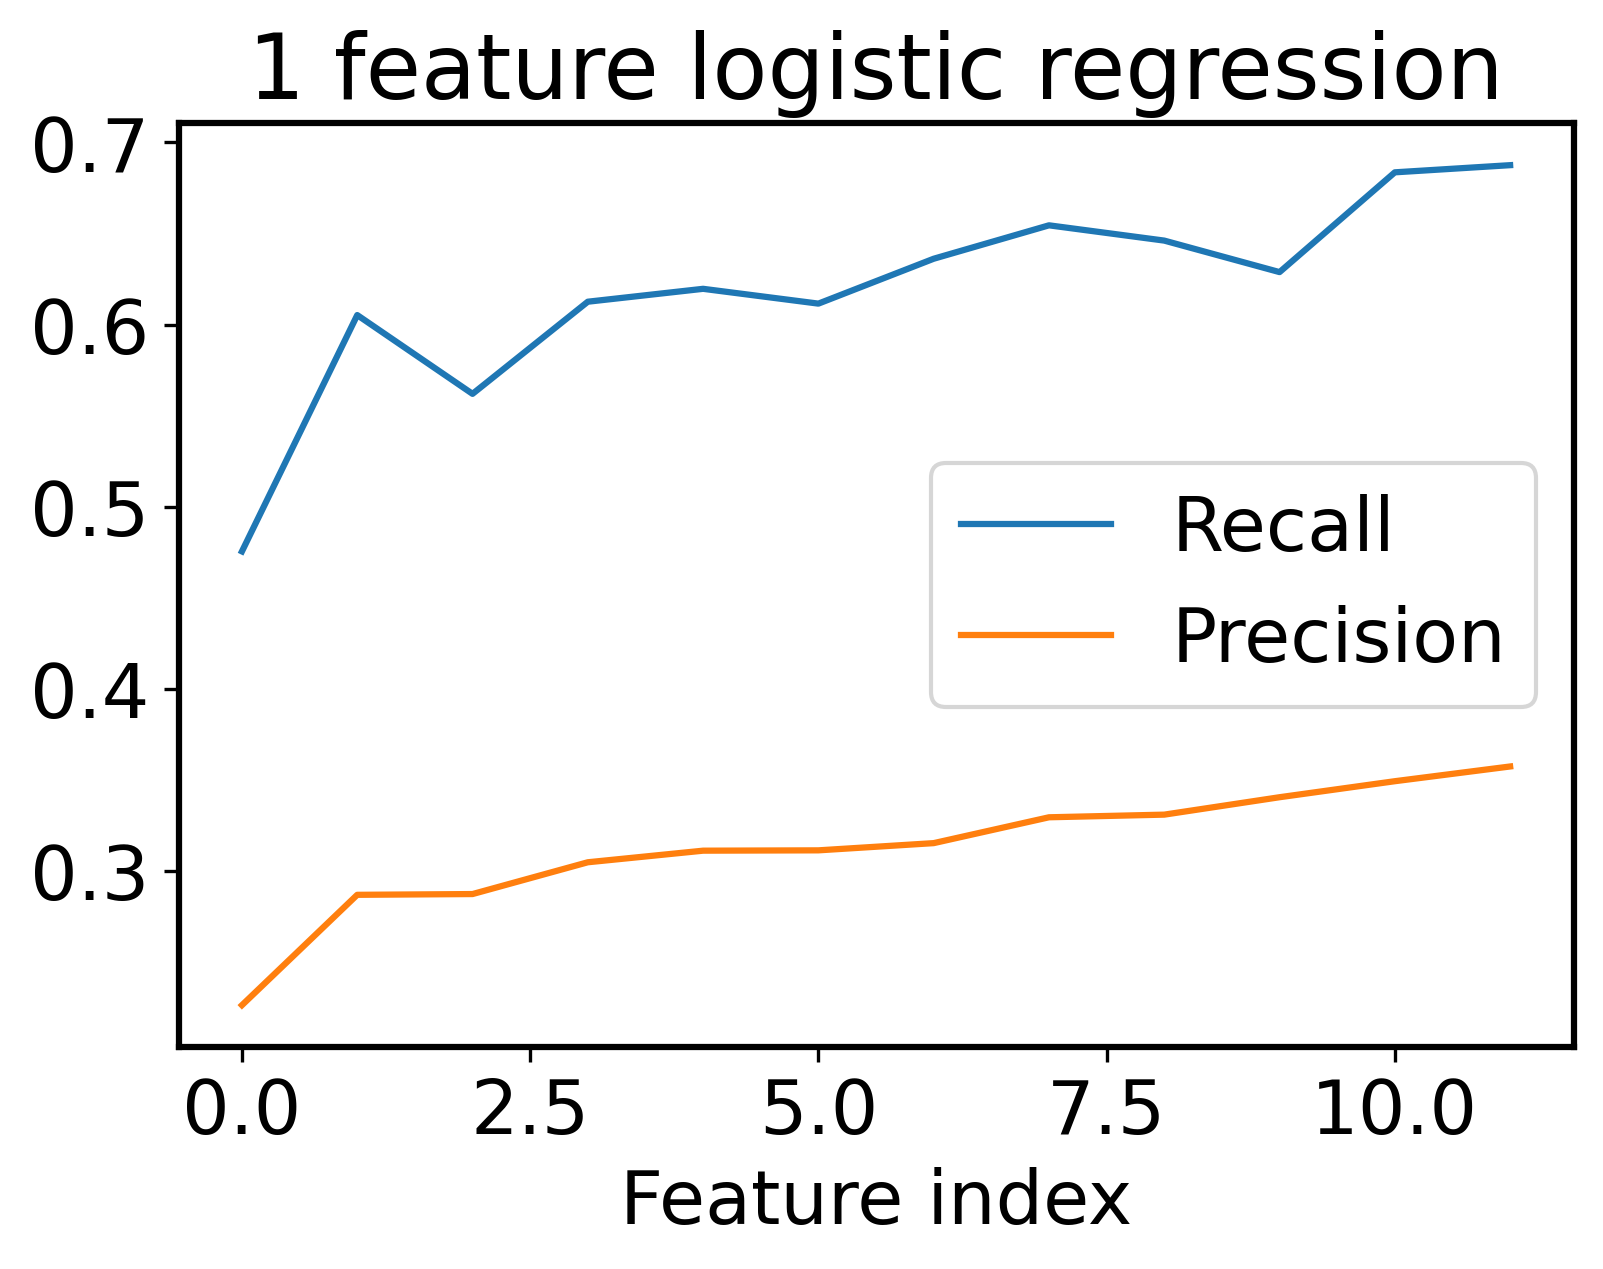

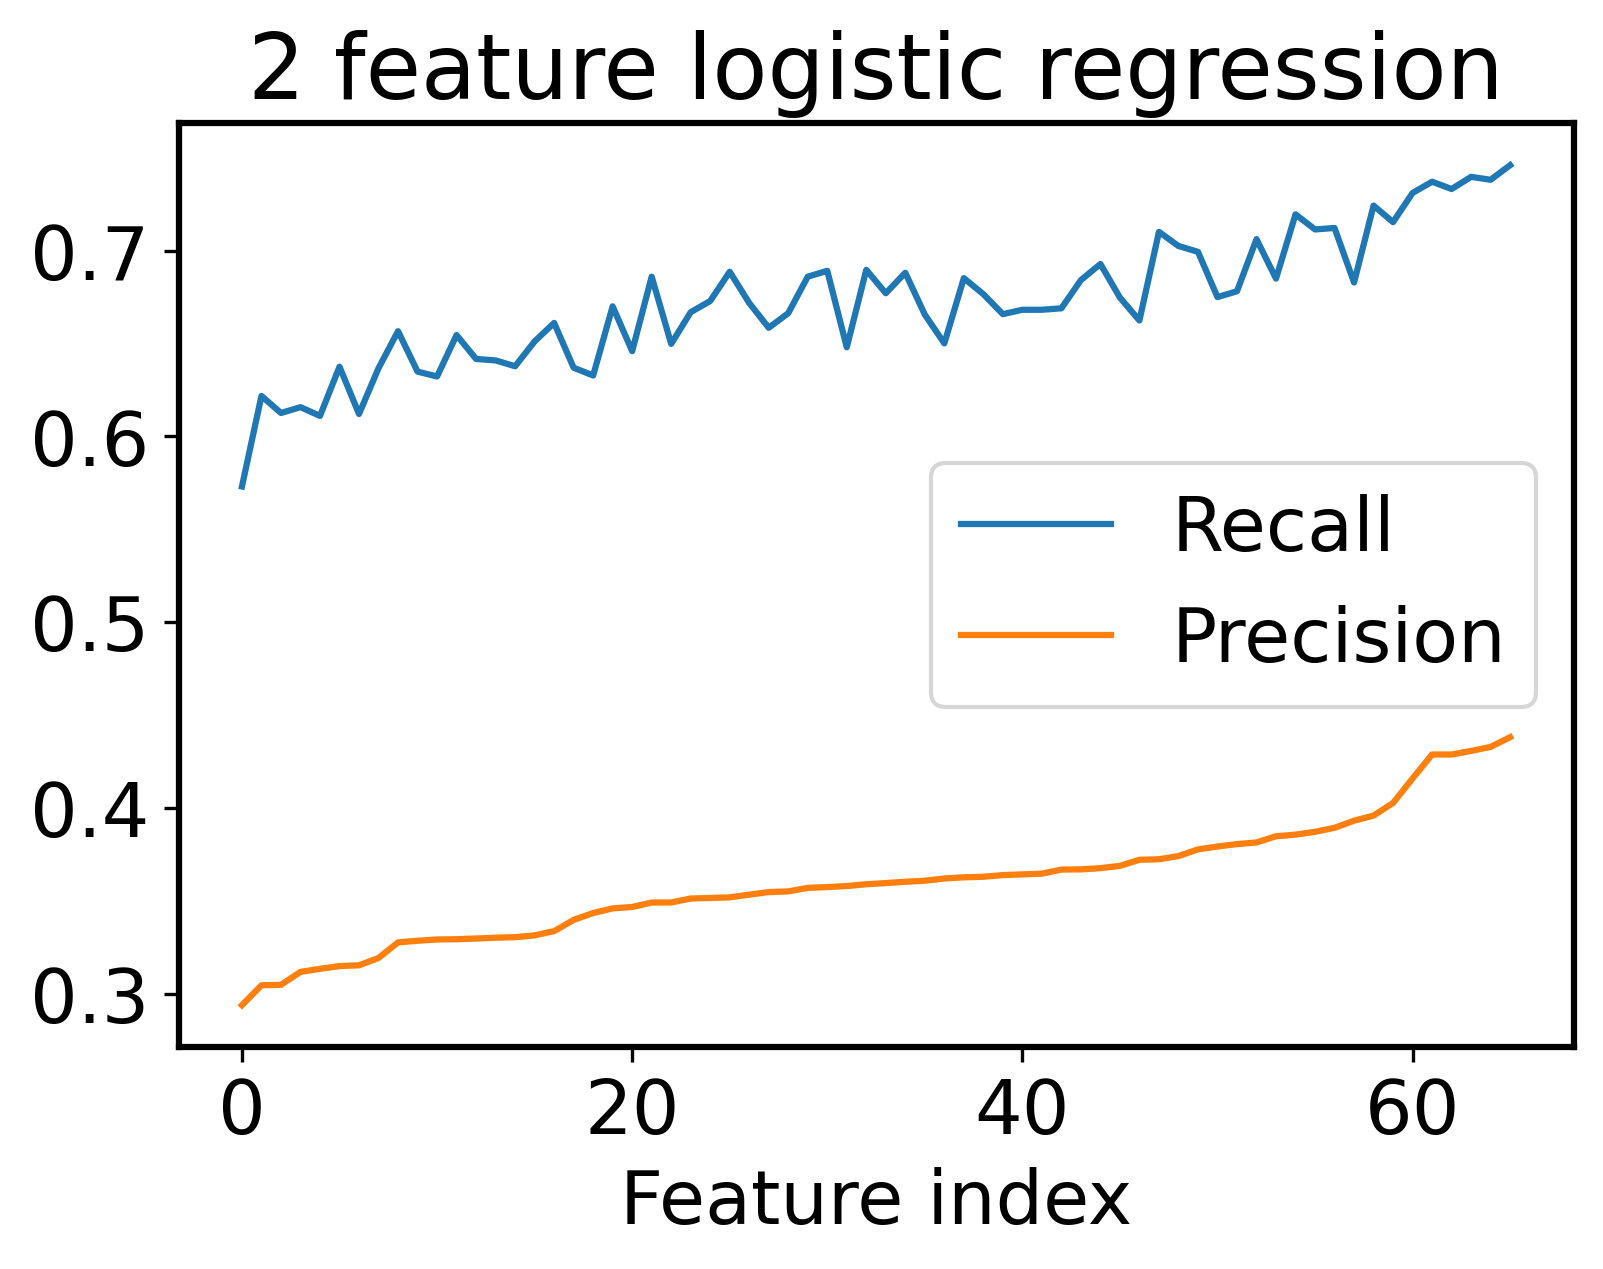

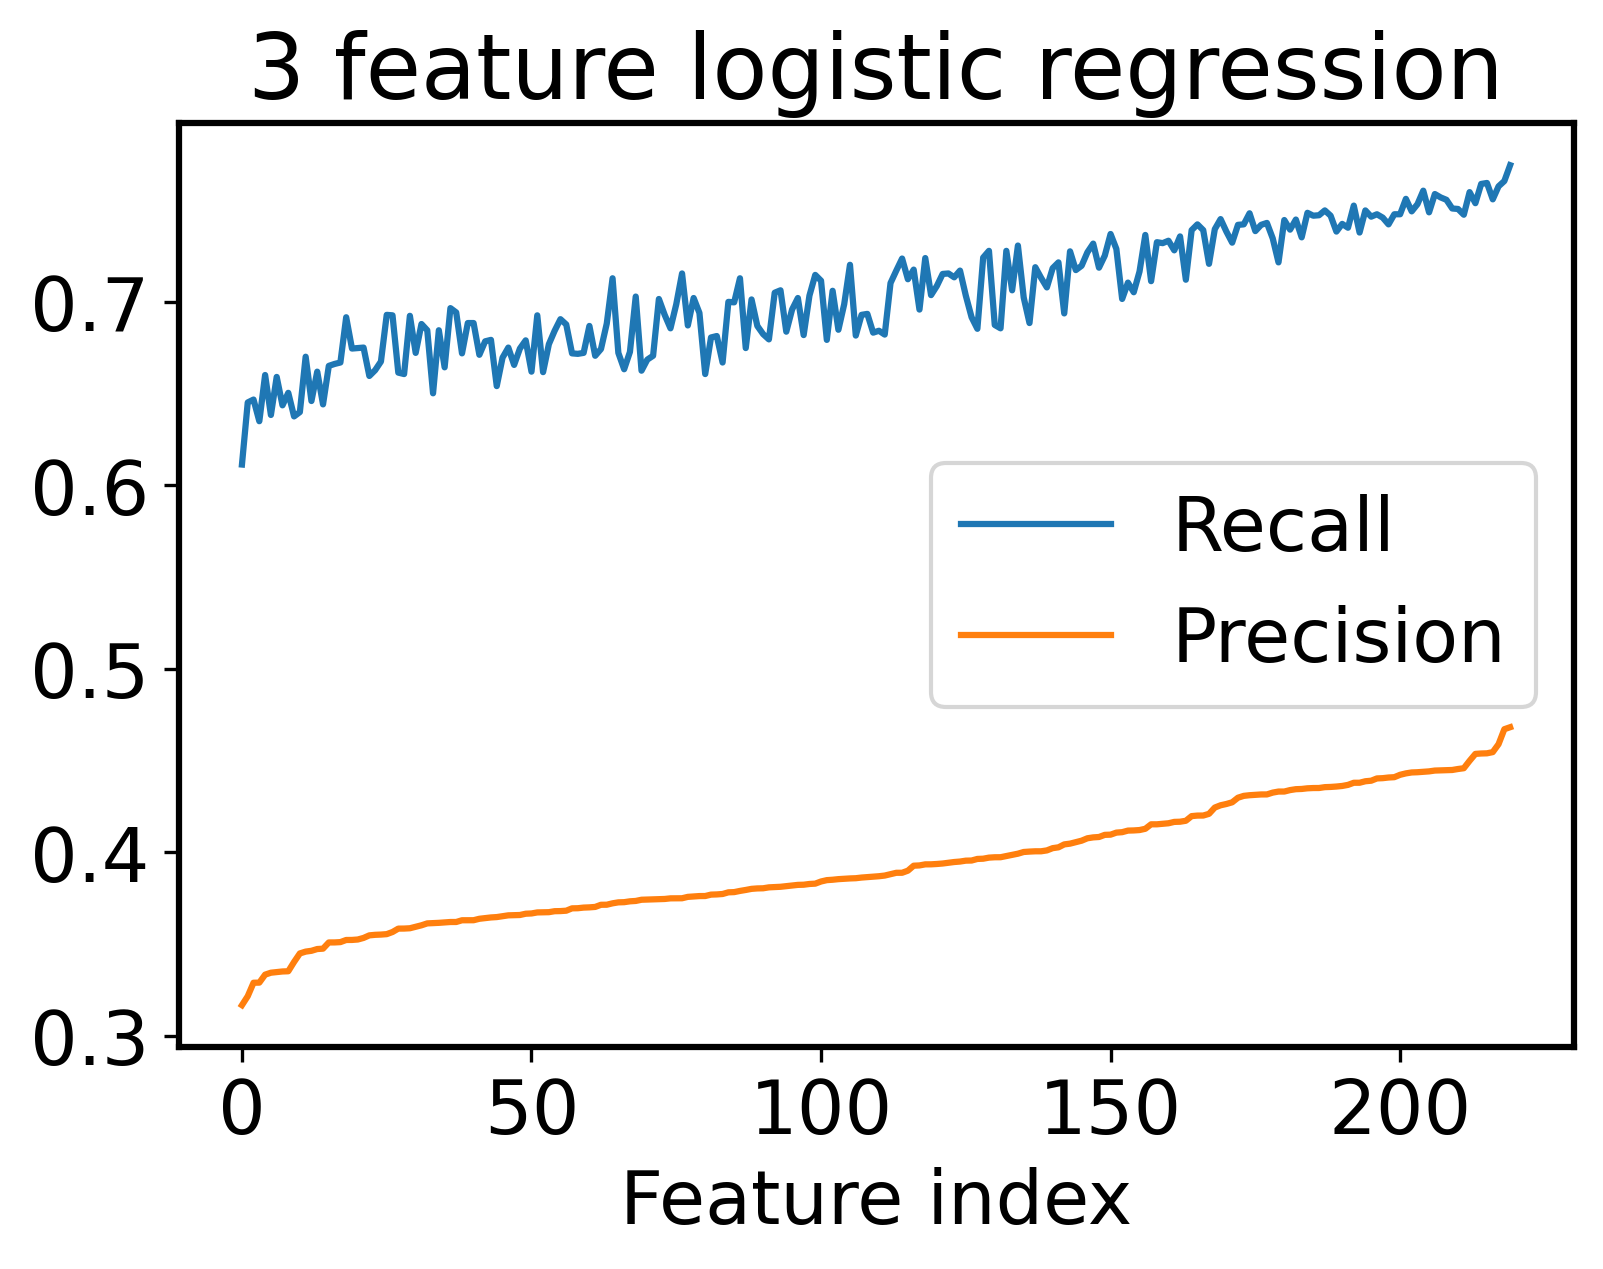

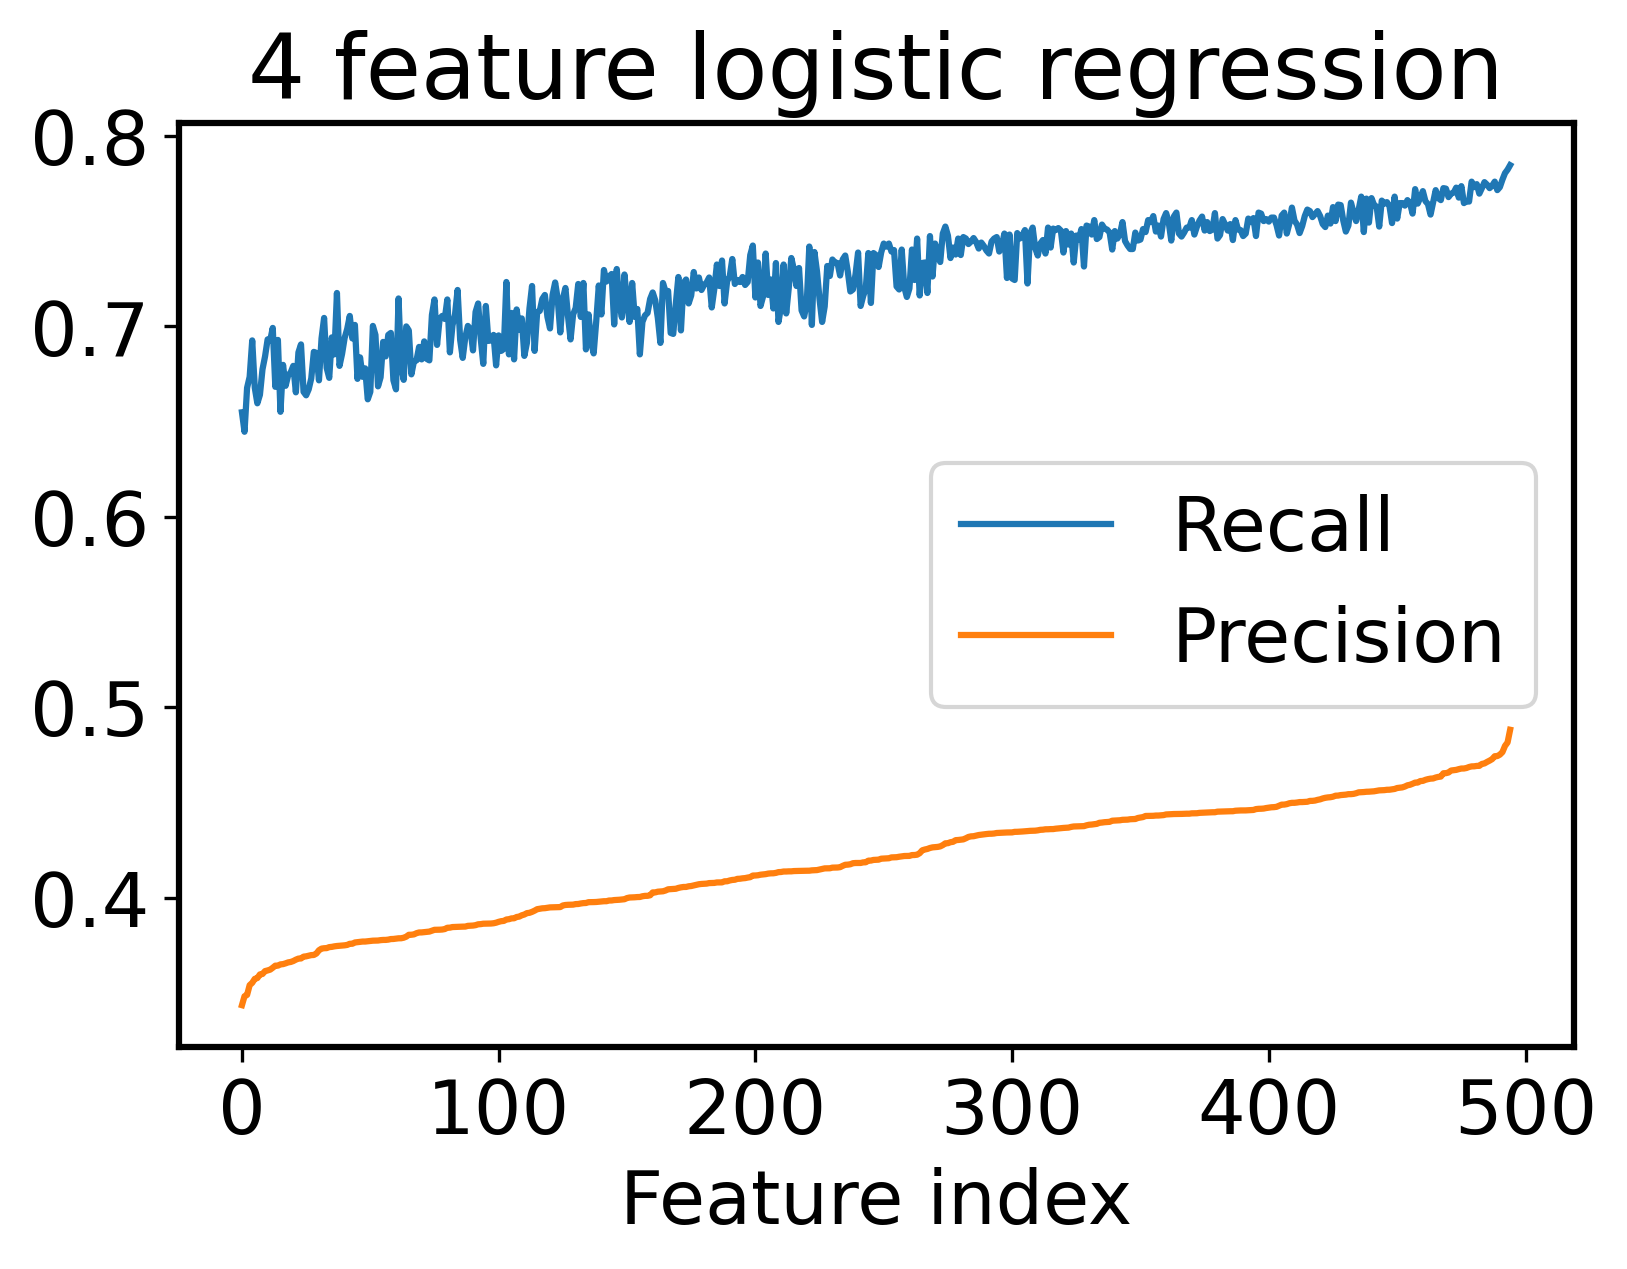

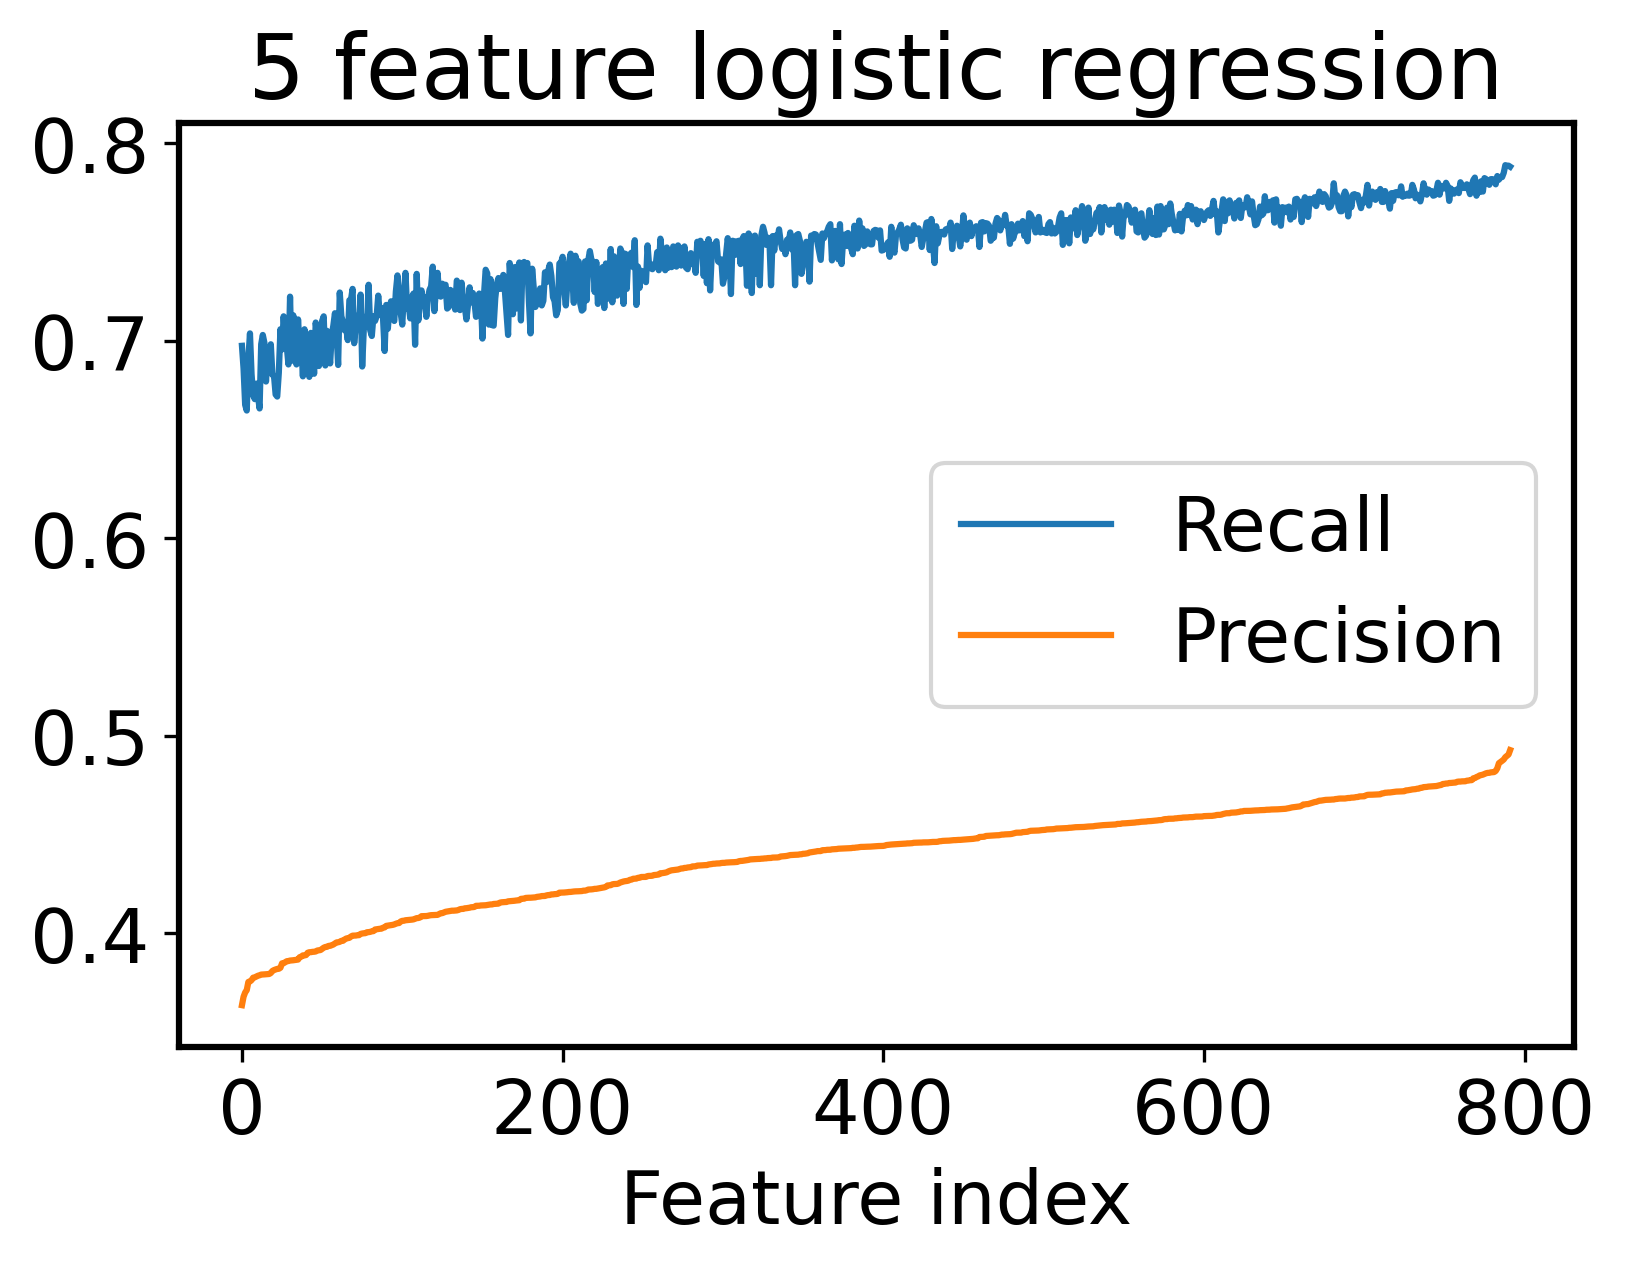

In [13]:
epoch=30
sparsemodel="logistic"

sup_recall=[]
sup_precision=[]
sup_combination=[]
sup_binaryentropy=[]
data_recall=[]
data_precision=[]
data_binaryentropy=[]
# for r in [1,2,3,4]:
#     print(r)
#     list_total=rSubset(arr, r)
    
for r in np.arange(1,6):
    print(r)
    list_total=list(combinations([i for i in range(12)], r))
    combination_feature_list=[   [my_dict[x] for x in feature_ind]  for feature_ind in list_total    ]
    recall=np.zeros( (len(list_total),))
    precision=np.zeros( (len(list_total),))
    binaryentropy=np.zeros( (len(list_total),))
    for i,subset in enumerate(list_total):
        x=train_x[:,subset] 
        if sparsemodel=="logistic":
            model = LogisticRegression(penalty='l1', C=1,solver='liblinear',\
                                       class_weight=class_weight).fit(x, train_ysparse)
        if sparsemodel=="tree":
            model = DecisionTreeClassifier(max_depth=3,class_weight="balanced")
            model.fit(x,train_y)
        y_pred=model.predict(test_x[:,subset] )
        recall[i]=(recall_score(test_ysparse, y_pred, labels=1))
        precision[i]=(precision_score(test_ysparse, y_pred, labels=1))  
        
        binaryentropy[i]=log_loss(test_y, model.predict_proba( test_x[:,subset] ))  
    
    sort_ind=np.argsort(precision)
    print(np.array(precision)[sort_ind],np.array(combination_feature_list)[sort_ind])
    print(list_total[np.argmax(precision)],combination_feature_list[np.argmax(precision)])
    data_recall.append(recall)
    data_precision.append(precision)
    data_binaryentropy.append(binaryentropy)
    
    sup_recall.append(recall[np.argmax(precision)])
    sup_precision.append(precision[np.argmax(precision)])
    sup_combination.append(combination_feature_list[np.argmax(precision)] )
    sup_binaryentropy.append(binaryentropy[np.argmax(precision)])
    fig,ax=plt.subplots(figsize=[6,4])
    
    ax.plot(recall[sort_ind])
    ax.plot(precision[sort_ind])
    ax.legend(["Recall","Precision"])
    ax.set_xlabel("Feature index")
    # ax.set_xticklabels(list_total)
    ax.set_title("%d feature logistic regression"%r)


In [14]:
sup10_recall=[(np.sort(data)[::-1][:10]) for data in data_recall]
sup10_precision=[(np.sort(data)[::-1][:10]) for data in data_precision]

sup recall= [0.6875491480996068, 0.746002621231979, 0.7743119266055046, 0.7845347313237222, 0.7882044560943644]
sup precision= [0.3574056410955171, 0.43804832999846083, 0.4682200031700745, 0.4880952380952381, 0.49278924942641755]


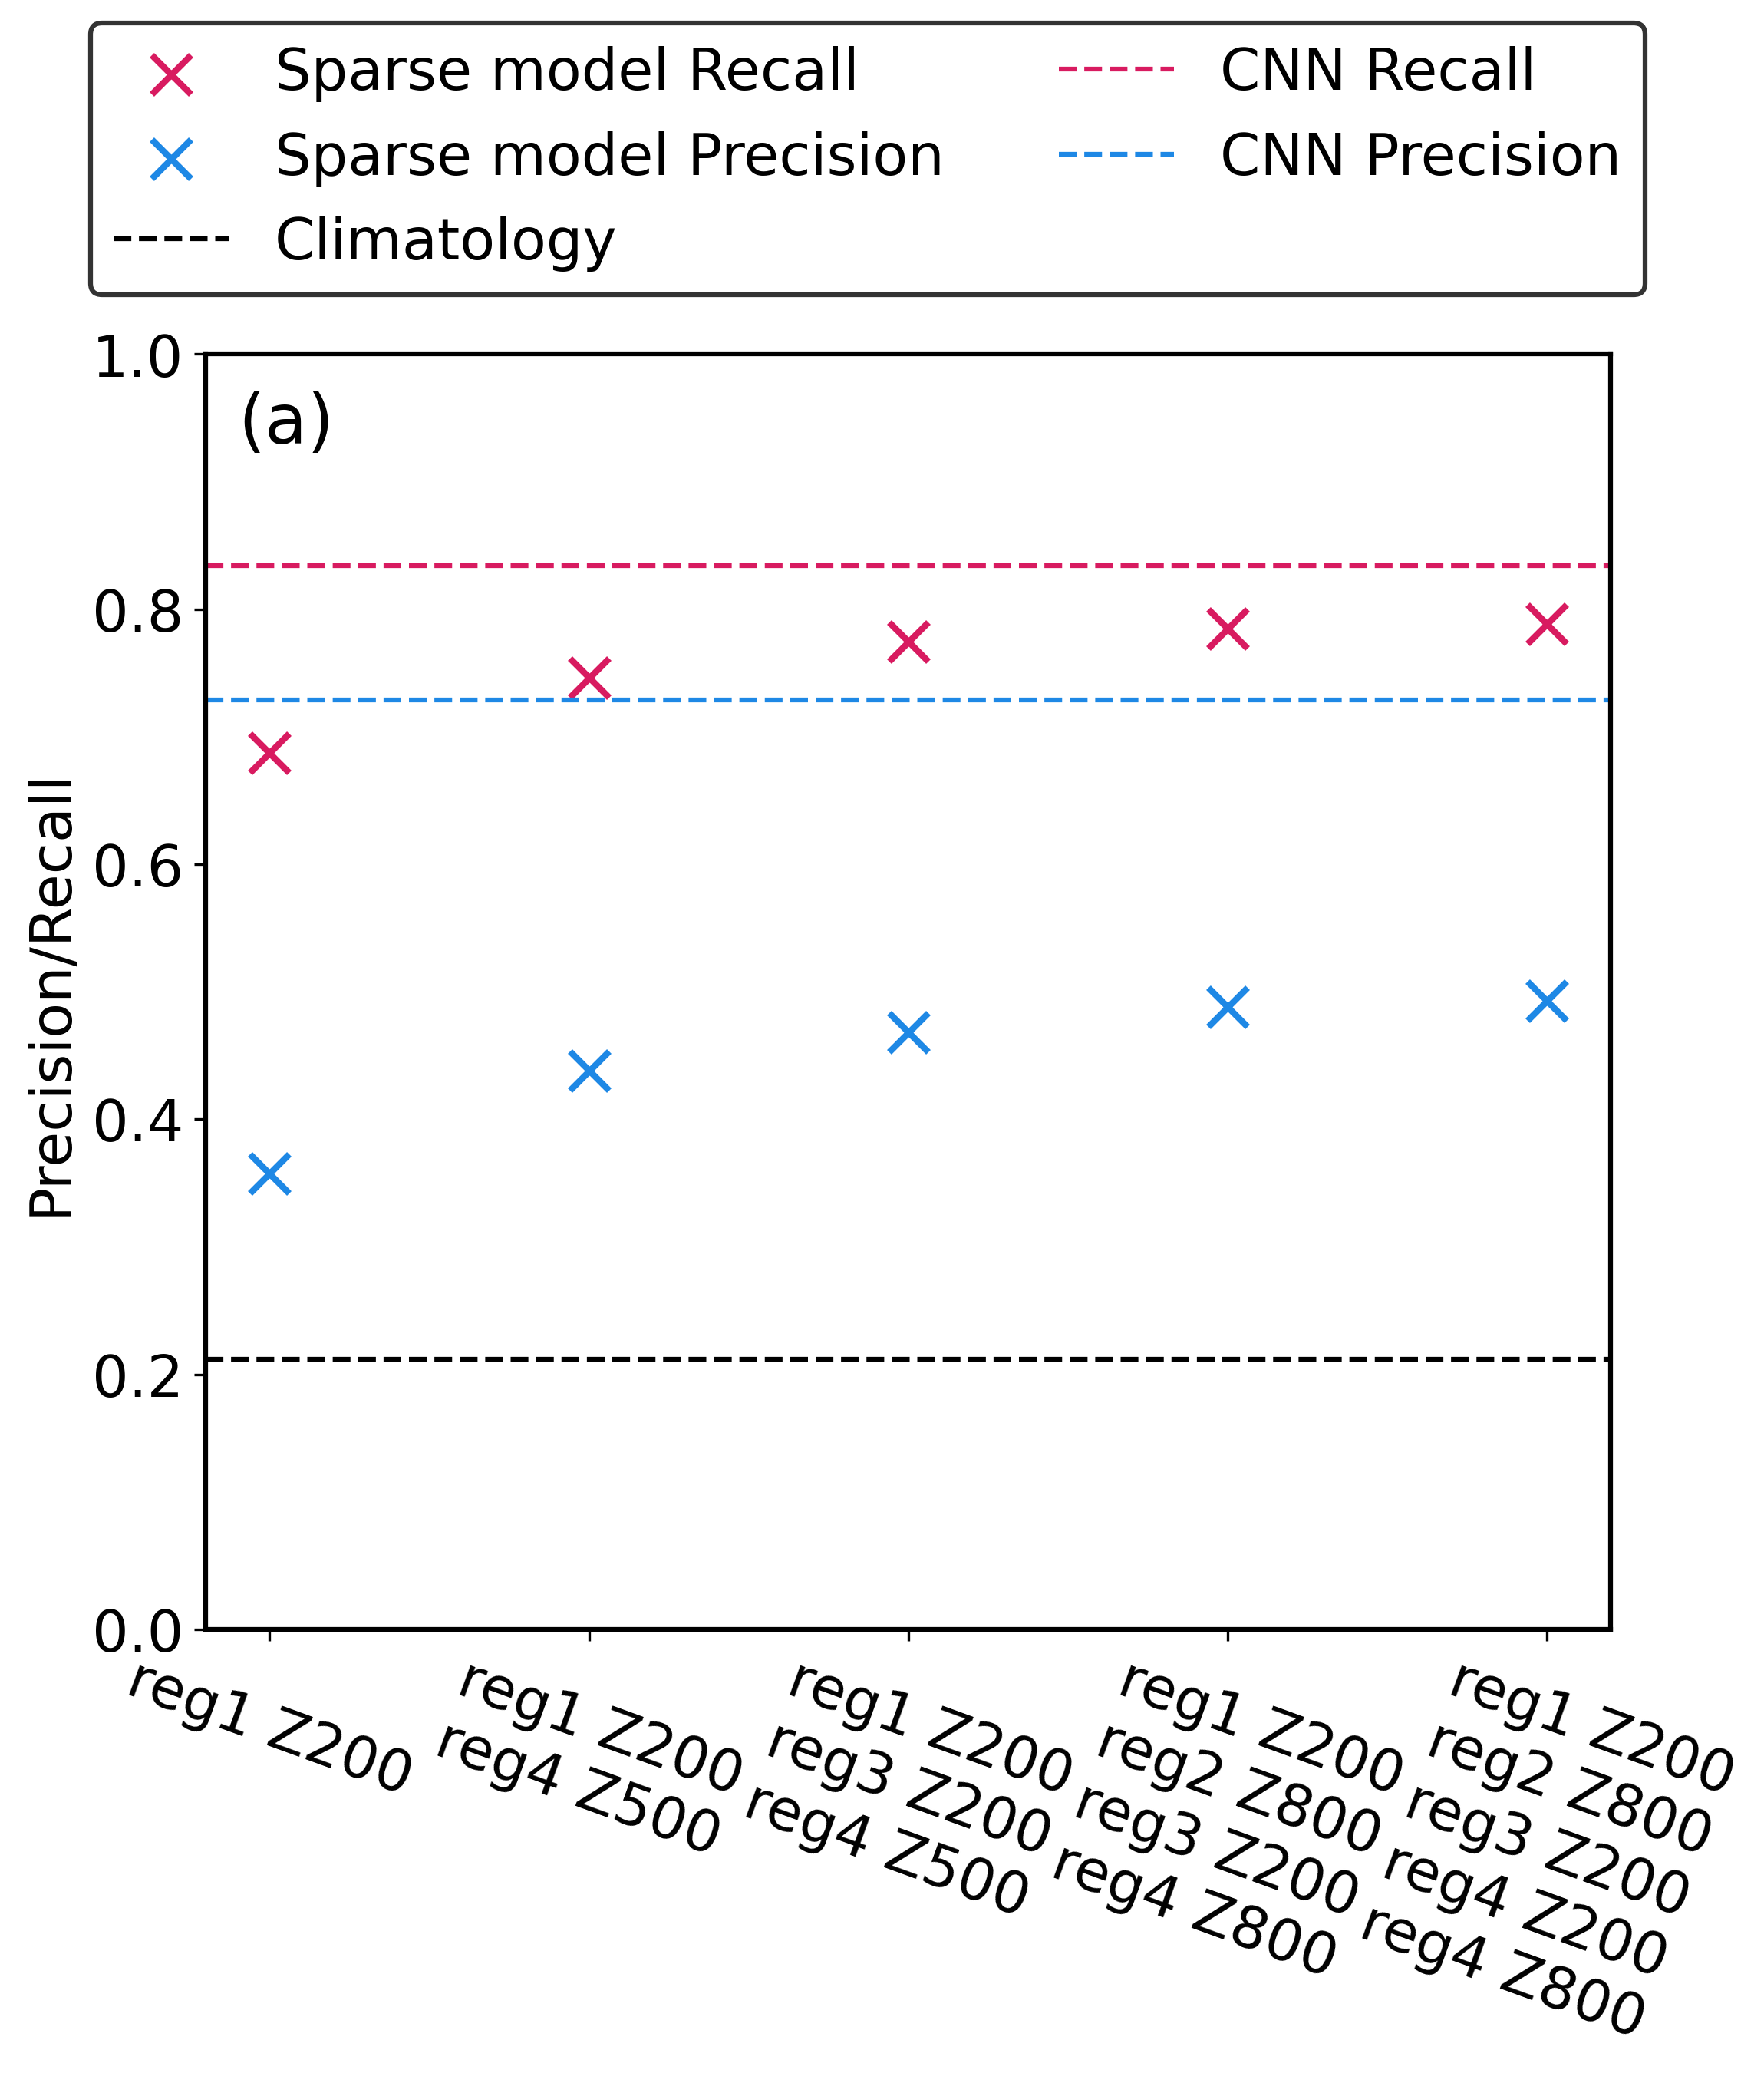

In [15]:
sq=True
if sq:
    color1="#D81B60"
    color2="#1E88E5"
    xticklabel=['\n'.join(item) for item in sup_combination]   
    fig,ax=plt.subplots(figsize=[8,8])
    p1=ax.scatter(np.arange(5),sup_recall,marker="x", s=150,linewidth=2,label="Sparse model Recall",color=color1)
    p2=ax.scatter(np.arange(5),sup_precision,marker="x",s=150,linewidth=2,label= "Sparse model Precision",color=color2)
    print("sup recall=", sup_recall)
    print("sup precision=",sup_precision)
    ax.set_ylabel("Precision/Recall")
    ax.set_xticks([i for i in range(len(sup_recall))])
    ax.set_xticklabels(xticklabel)
    plt.xticks(rotation = -20)

    ax.set_ylim([0,1])
    ax.axhline(y=Ysparse.sum()/Ysparse.size,label="Climatology",linestyle='--',color='k')
    ax.axhline(y=0.834,label="CNN Recall",linestyle='--',color=color1)
    ax.axhline(y=0.729,label= "CNN Precision",linestyle='--',color=color2)

    handles, labels = ax.get_legend_handles_labels()
    leg=fig.legend(handles, labels, bbox_to_anchor=(0.93, 1.15),ncol=2)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(1.5)
    leg.get_frame().set_linewidth(1.5)
    ax.text(-0.1,0.93, "(a)"  ,fontsize="large")

    fig.tight_layout()
    fig.savefig("Fig8_sparse-model_sq.png", bbox_inches = "tight")

In [ ]:
if sq==False:
    color1="#D81B60"
    color2="#1E88E5"
    xticklabel=['\n'.join(item) for item in sup_combination]   
    fig,ax=plt.subplots(figsize=[8,8])
    p1=ax.scatter(np.arange(5),sup_recall,marker="x", s=150,linewidth=2,label="Sparse model Recall",color=color1)
    p2=ax.scatter(np.arange(5),sup_precision,marker="x",s=150,linewidth=2,label= "Sparse model Precision",color=color2)
    print("sup recall=", sup_recall)
    print("sup precision=",sup_precision)

    ax.set_xticks([i for i in range(len(sup_recall))])
    ax.set_xticklabels(xticklabel)
    plt.xticks(rotation = -20)

    ax.set_ylim([0,1])
    ax.axhline(y=Ysparse.sum()/Ysparse.size,label="Climatology",linestyle='--',color='k')
    ax.axhline(y=0.834,label="CNN Recall",linestyle='--',color=color1)
    ax.axhline(y=0.729,label= "CNN Precision",linestyle='--',color=color2)


    handles, labels = ax.get_legend_handles_labels()
    leg=fig.legend(handles, labels, bbox_to_anchor=(0.95, 1.15),ncol=2)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(1.5)
    leg.get_frame().set_linewidth(1.5)



    fig.tight_layout()
    fig.savefig("Fig7_sparse-model.png", bbox_inches = "tight")

/state/partition1/job-44937222/ipykernel_2542940/243911719.py:20: RuntimeWarning: Mean of empty slice.
  mean[i,j]= samples.mean()


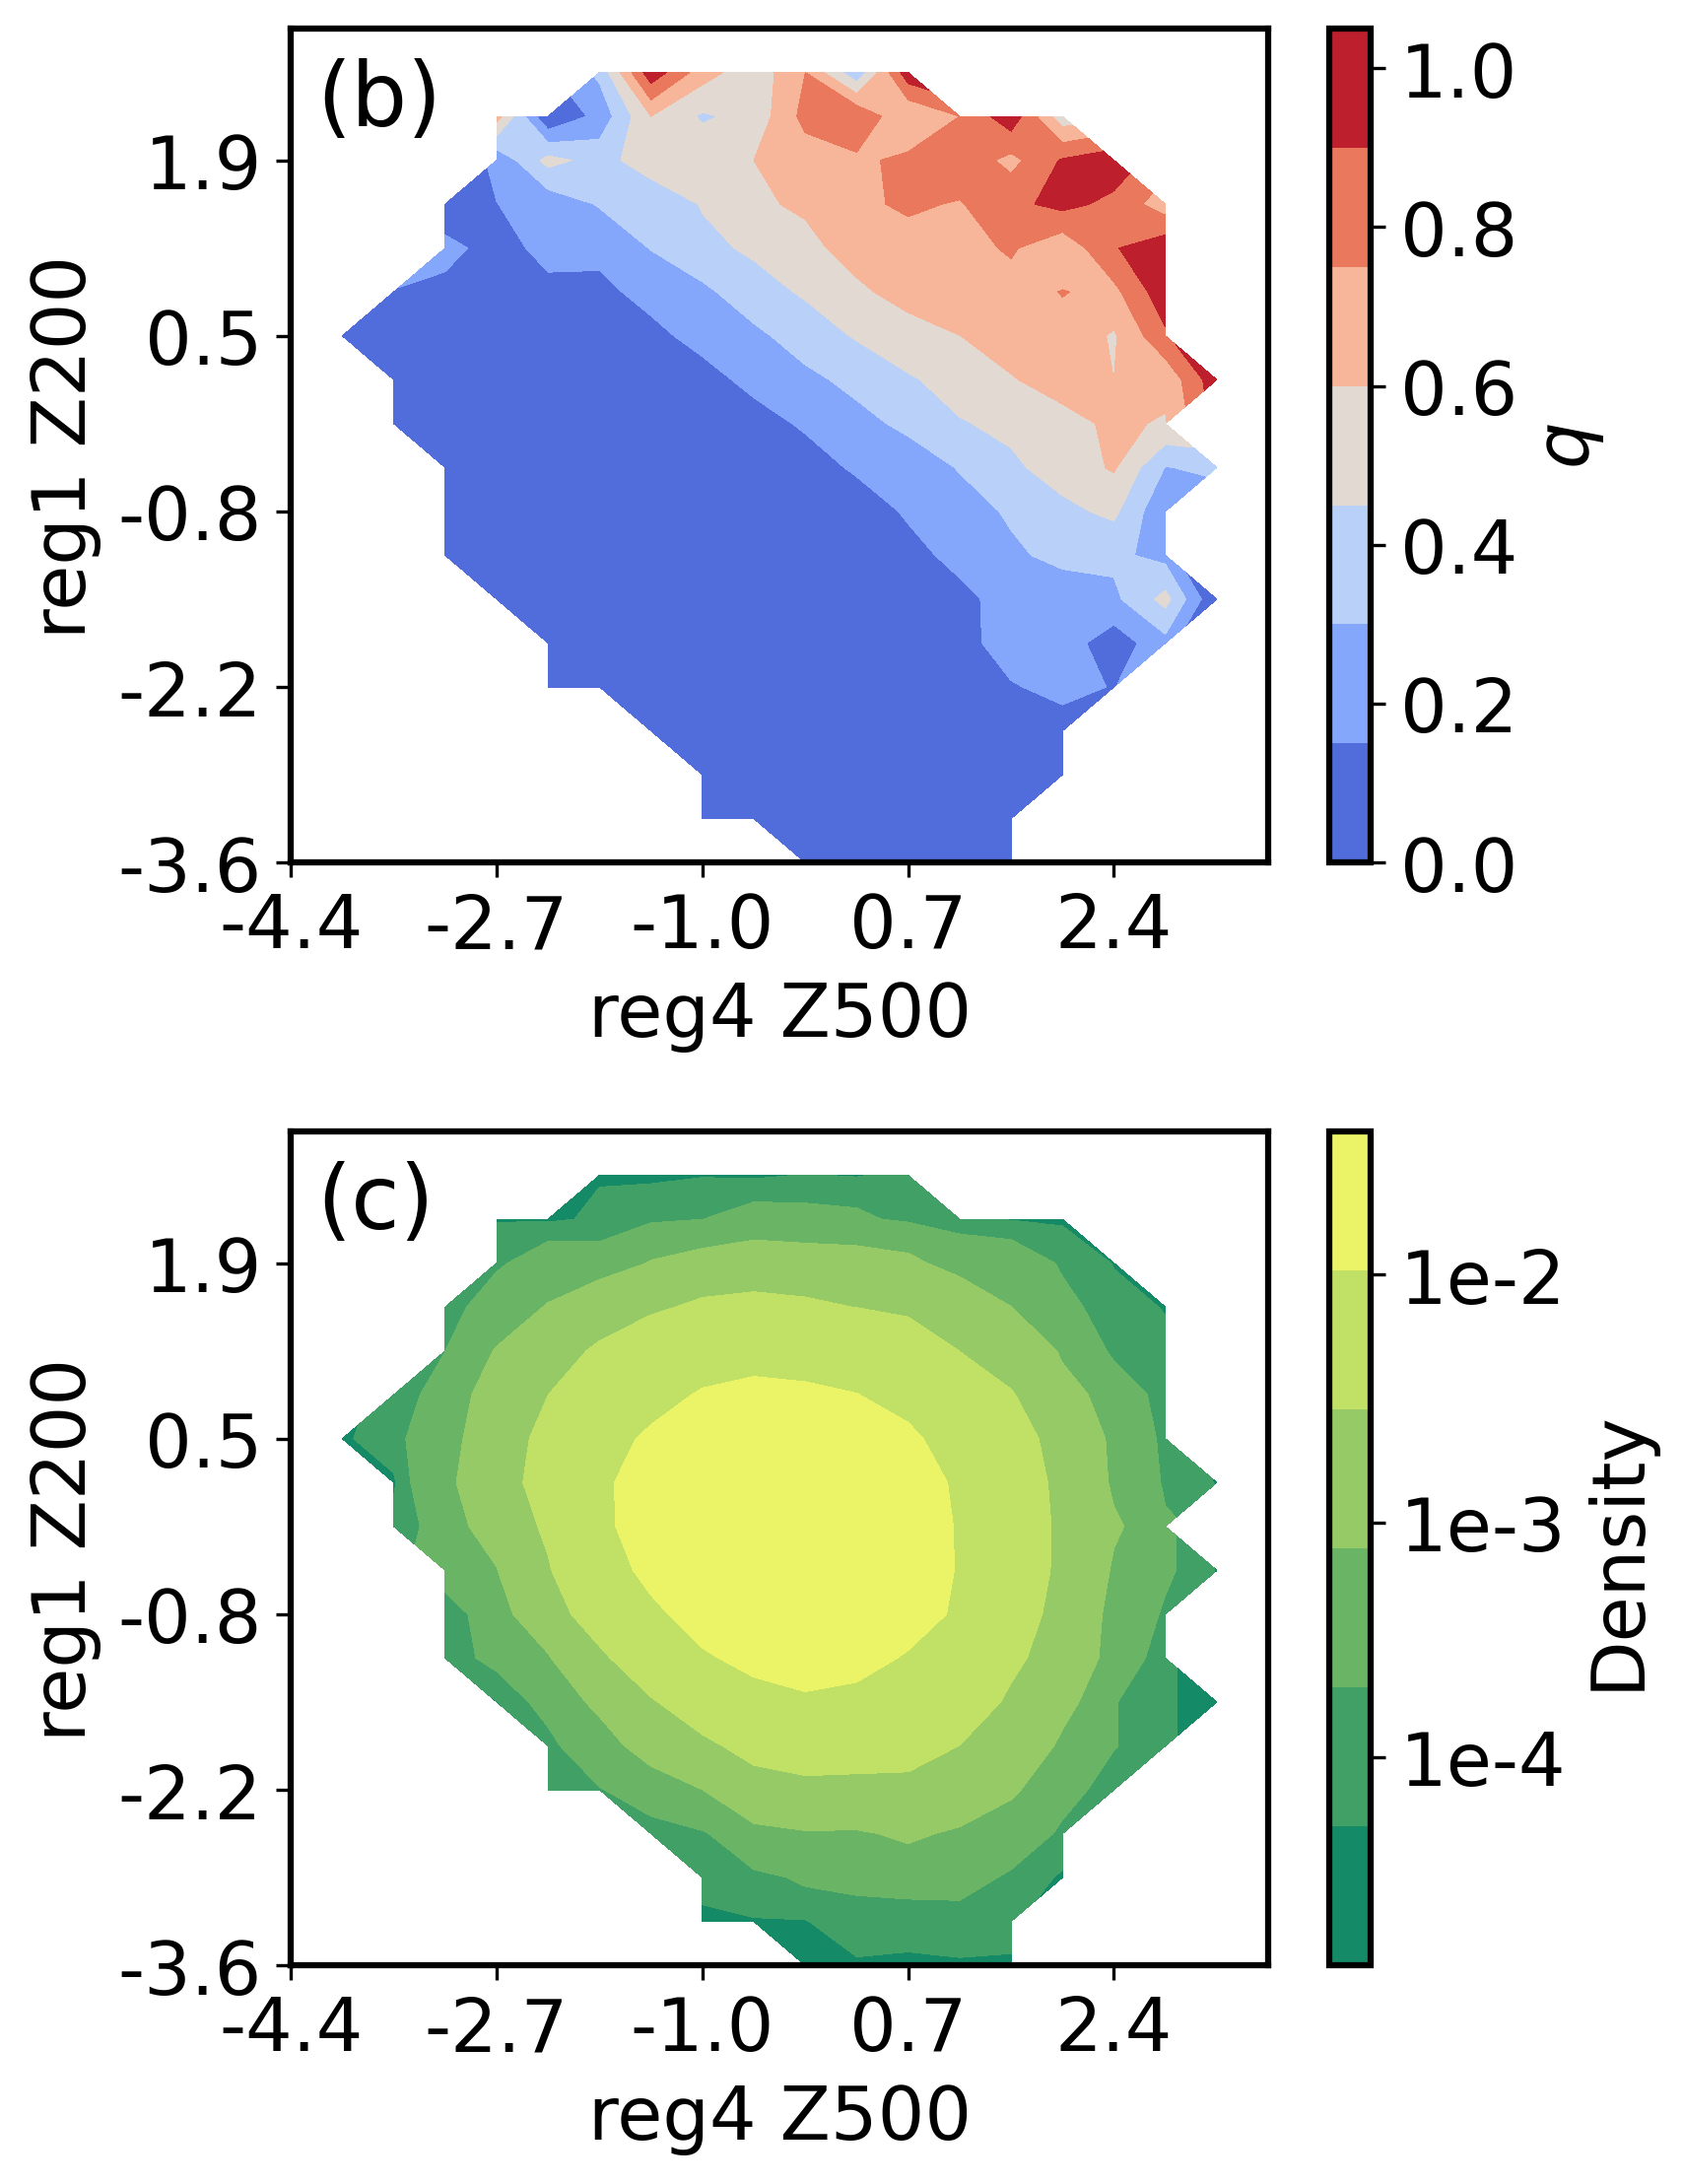

In [40]:
def plot2d(x,y,xname,yname,Ysparse, otherinformation=None, number_bins=20,density_threshold=1e-4, ):
    xmin=x.min()
    xmax=x.max()
    intervalx=np.linspace(x.min(),x.max(),number_bins)
    dx=intervalx[1]-intervalx[0]
    
    ymin=y.min()
    ymax=y.max()
    intervaly=np.linspace(y.min(),y.max(),number_bins)
    dy=intervaly[1]-intervaly[0]    
    samples_class= [ [[]    for i in range(number_bins) ]    for j in range(number_bins) ]
    mean=np.zeros((number_bins,number_bins))
    std=np.zeros((number_bins,number_bins))
    density=np.zeros((number_bins,number_bins))
    for t in range(x.shape[0]):
        samples_class[int((x[t]-xmin)/dx)][int((y[t]-ymin)/dy)].append(Ysparse[t])
    for i in range(number_bins):
        for j in range(number_bins):
            samples=np.array(samples_class[i][j])
            mean[i,j]= samples.mean() 
            std[i,j]= samples.std() 
            density[i,j]=samples.size/x.shape[0]
    density=ma.masked_where(density<density_threshold, density) 
    mean=ma.masked_where(density<density_threshold, mean) 
    std=ma.masked_where(density<density_threshold, std) 
    fig,ax=plt.subplots(figsize=[6,8],nrows=2,sharey=True)
    c=ax[0].contourf(mean,cmap="coolwarm", vmax=1, vmin=0) 
    cbar=plt.colorbar(c,ax=ax[0])
    cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
    cbar.set_label(r'$q$')
    c=ax[1].contourf(density,cmap="summer",levels=[1e-5*4**i for i in range(7)], \
                     locator=mticker.LogLocator()) 
    cbar=plt.colorbar(c,ax=ax[1],format='%.0e')
    cbar.set_ticks([1e-4, 1e-3, 1e-2]) 
    cbar.set_ticklabels(["1e-4", "1e-3", "1e-2"]) 
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    cbar.set_label('Density')
    for a in ax:
        a.set_xticks(np.arange(0,len(intervaly),4))
        a.set_yticks(np.arange(0,len(intervalx),4))
        a.set_xticklabels(["%.1f"%_ for _ in intervaly[::4]])
        a.set_yticklabels(["%.1f"%_ for _ in intervalx[::4]])
        a.set_xlabel(yname)
        a.set_ylabel(xname)

    plt.suptitle(otherinformation)
    fig.tight_layout()
    return fig,ax


import numpy.ma as ma
fig,ax=plot2d(data_x[:,0],data_x[:,10],"","",Ysparse,"",density_threshold=2e-5)

ax[0].set_ylabel("reg1 Z200") 
ax[1].set_ylabel("reg1 Z200") 
ax[0].set_xlabel("reg4 Z500")
ax[1].set_xlabel("reg4 Z500")
# ax[0].set_xlim([-4.4,3.1])
# ax[0].set_ylim([-3.6,4])
ax[0].text(0.5,16.8, "(b)"  ,fontsize="large")
ax[1].text(0.5,16.8, "(c)"  ,fontsize="large")
fig.tight_layout()
if sq:
    fig.savefig("Fig8_committor_sq.png", bbox_inches = "tight")
else:
    fig.savefig("Fig8_committor.png", bbox_inches = "tight")